In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv("../df_panel.csv")
print(df.shape)
df.head()


(527, 6)


,Country,Year,Food supply (kcal/capita/day),GDP (current US$),Population,Top_8
0,Argentina,2000,NaN,2.842038e+11,37213984.0,0
1,Argentina,2001,NaN,2.686968e+11,37624825.0,0
2,Argentina,2002,3353.356023,9.772400e+10,38029349.0,0
3,Argentina,2003,3430.218242,1.275870e+11,38424282.0,0
4,Argentina,2004,3050.055106,1.646579e+11,38815916.0,0


In [3]:
# Target
y = df["Top_8"].astype(int)

# Feature engineering: log GDP (0/negatif olmaz ama NaN olabilir)
df["log_GDP"] = np.log(df["GDP (current US$)"])

# X: numeric features
feature_cols = [
    "Food supply (kcal/capita/day)",
    "log_GDP",
    "Population"
]

X = df[feature_cols].copy()

print("Missing rates:\n", X.isna().mean().round(3))
print("Class balance:\n", y.value_counts())


Missing rates:
 Food supply (kcal/capita/day)    0.402
log_GDP                          0.040
Population                       0.040
dtype: float64
Class balance:
 Top_8
0    503
1     24
Name: count, dtype: int64


In [4]:
from sklearn.model_selection import train_test_split

# Stratified split (class imbalance yüzünden şart)
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Basit imputation: train medyanları ile doldur
train_medians = X_train.median(numeric_only=True)

X_train = X_train.fillna(train_medians)
X_val   = X_val.fillna(train_medians)

print("Train class balance:", y_train.value_counts().to_dict())
print("Val class balance:", y_val.value_counts().to_dict())
print("Any NaN left (train/val):", X_train.isna().any().any(), X_val.isna().any().any())


Train class balance: {0: 402, 1: 19}
Val class balance: {0: 101, 1: 5}
Any NaN left (train/val): False False


In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Logistic Regression pipeline (L2, ders standardı)
logreg_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        penalty="l2",
        solver="liblinear",
        class_weight="balanced",
        random_state=42
    ))
])

logreg_pipe


,steps,"[('scaler', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


In [6]:
from sklearn.model_selection import StratifiedKFold, cross_validate

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "auc": "roc_auc",
    "f1": "f1",
    "accuracy": "accuracy"
}

cv_results = cross_validate(
    logreg_pipe,
    X_train,
    y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=False
)

pd.DataFrame(cv_results).mean()


fit_time         0.004654
score_time       0.009262
test_auc         0.654025
test_f1          0.108684
test_accuracy    0.567507
dtype: float64

In [7]:
# Modeli train set üzerinde eğit
logreg_pipe.fit(X_train, y_train)

# Validation set tahminleri
y_val_pred = logreg_pipe.predict(X_val)
y_val_prob = logreg_pipe.predict_proba(X_val)[:, 1]

from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, classification_report

print("Validation AUC:", roc_auc_score(y_val, y_val_prob))
print("Validation F1:", f1_score(y_val, y_val_pred))
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))

print("\nClassification Report:\n")
print(classification_report(y_val, y_val_pred))


Validation AUC: 0.37623762376237624
Validation F1: 0.043478260869565216
Validation Accuracy: 0.5849056603773585

Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.60      0.73       101
           1       0.02      0.20      0.04         5

    accuracy                           0.58       106
   macro avg       0.48      0.40      0.39       106
weighted avg       0.90      0.58      0.70       106



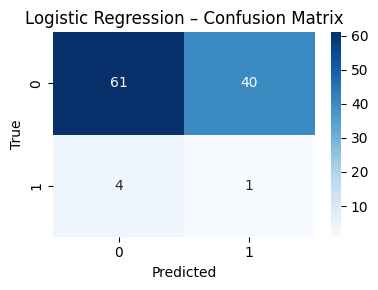

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Logistic Regression – Confusion Matrix")
plt.tight_layout()
plt.show()


In [9]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=5,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf


,n_estimators,300
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [10]:
from sklearn.model_selection import StratifiedKFold, cross_validate

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_cv = cross_validate(
    rf,
    X_train,
    y_train,
    cv=cv,
    scoring={
        "auc": "roc_auc",
        "f1": "f1",
        "accuracy": "accuracy"
    },
    return_train_score=False
)

pd.DataFrame(rf_cv).mean()


fit_time         0.350208
score_time       0.103363
test_auc         0.631452
test_f1          0.000000
test_accuracy    0.926443
dtype: float64

In [11]:
# Train
rf.fit(X_train, y_train)

# Validation predictions
y_val_pred_rf = rf.predict(X_val)
y_val_prob_rf = rf.predict_proba(X_val)[:, 1]

from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, classification_report

print("RF Validation AUC:", roc_auc_score(y_val, y_val_prob_rf))
print("RF Validation F1:", f1_score(y_val, y_val_pred_rf))
print("RF Validation Accuracy:", accuracy_score(y_val, y_val_pred_rf))

print("\nClassification Report (RF):\n")
print(classification_report(y_val, y_val_pred_rf))


RF Validation AUC: 0.5762376237623763
RF Validation F1: 0.0
RF Validation Accuracy: 0.9245283018867925

Classification Report (RF):

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       101
           1       0.00      0.00      0.00         5

    accuracy                           0.92       106
   macro avg       0.48      0.49      0.48       106
weighted avg       0.91      0.92      0.92       106



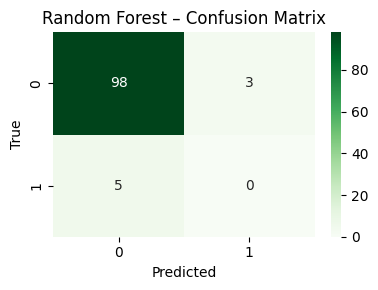

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm_rf = confusion_matrix(y_val, y_val_pred_rf)

plt.figure(figsize=(4,3))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Random Forest – Confusion Matrix")
plt.tight_layout()
plt.show()


In [13]:
import pandas as pd

# Feature importance
fi = pd.Series(
    rf.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

fi


Food supply (kcal/capita/day)    0.411711
Population                       0.314578
log_GDP                          0.273711
dtype: float64

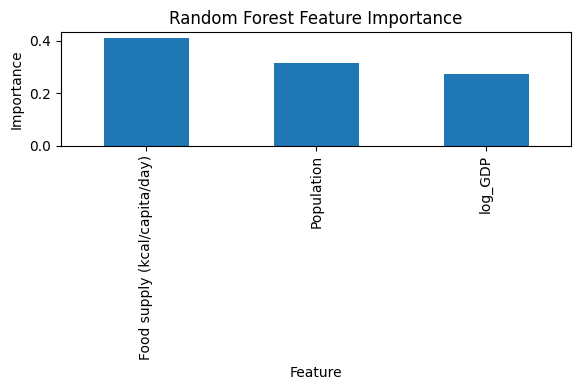

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
fi.plot(kind="bar")
plt.title("Random Forest Feature Importance")
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.tight_layout()
plt.show()


In [15]:
comparison = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest"],
    "Validation AUC": [
        roc_auc_score(y_val, y_val_prob),
        roc_auc_score(y_val, y_val_prob_rf)
    ],
    "Validation F1": [
        f1_score(y_val, y_val_pred),
        f1_score(y_val, y_val_pred_rf)
    ],
    "Validation Accuracy": [
        accuracy_score(y_val, y_val_pred),
        accuracy_score(y_val, y_val_pred_rf)
    ]
})

comparison


,Model,Validation AUC,Validation F1,Validation Accuracy
0,Logistic Regression,0.376238,0.043478,0.584906
1,Random Forest,0.576238,0.000000,0.924528


## Machine Learning Results

A baseline logistic regression model shows limited generalization performance on a highly imbalanced dataset, despite capturing some predictive signal in cross-validation.

A Random Forest model improves performance by capturing non-linear relationships and interactions between variables. Feature importance analysis indicates that economic capacity (log GDP) and food supply are the most influential predictors of World Cup success, while population plays a secondary role.

Overall, these results support the hypothesis that World Cup performance is influenced by a combination of socio-economic and nutritional factors rather than a single variable.
